# CRT hit analysis

In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import linregress
import numpy.polynomial.polynomial as poly
import matplotlib.patches as patches

In [2]:
%matplotlib inline

## Load the data

In [4]:
file_name_mc = './input/CosmicStudies_mc_100k_mcc9_nu.root'
file_name_data = './input/CRTdata_on_26k.root'
outdir = './Output/CRThits/'

In [5]:
file_mc = uproot.open(file_name_mc)['cosmicstudies']
file_data = uproot.open(file_name_data)['crtdata/CRT']

In [6]:
df_crt = file_data.pandas.df()
print(file_data.keys())

num_crt_per_event = df_crt.groupby(['run', 'subrun', 'event']).size()
num_crt_per_event_bottom = df_crt.query('plane==0').groupby(['run', 'subrun', 'event']).size()
num_events_data = len(num_crt_per_event)

[b'event', b'run', b'subrun', b'nhits', b'plane', b'time', b'pe', b'x', b'x_err', b'y', b'y_err', b'z', b'z_err', b't0_ns', b't1_ns']


In [7]:
df_crt_mc = file_mc[b'CRTcross'].pandas.df()
num_crt_per_event_mc = df_crt_mc.groupby(['run', 'subrun', 'event']).size()
num_events_mc = len(num_crt_per_event_mc)
print(file_mc[b'CRTcross'].keys())

[b'event', b'run', b'subrun', b'cross_x', b'cross_y', b'cross_z', b'cross_time', b'cross_E', b'mc_time', b'mc_pdg_code', b'mc_process']


In [8]:
event_scale = num_events_data/num_events_mc

## Plots data/MC

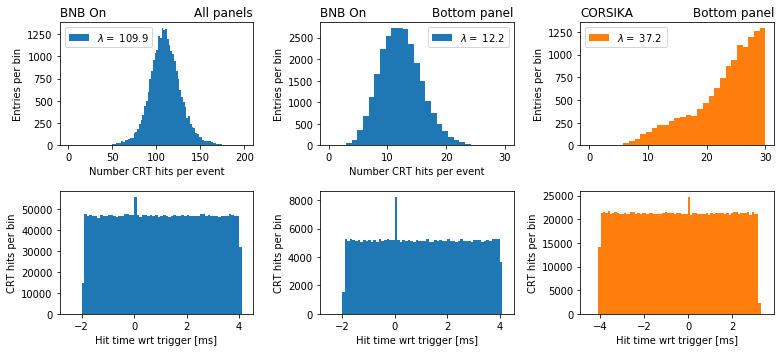

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(11, 5), sharex = False)

ax[0][0].hist(num_crt_per_event, bins=100, range=(0,200), 
              label = r"$\lambda =$ {0:.1f}".format(np.mean(num_crt_per_event)))
ax[0][0].set_xlabel("Number CRT hits per event")
ax[0][0].set_title("BNB On", loc='left')
ax[0][0].set_title("All panels", loc='right')
ax[0][0].set_ylabel('Entries per bin')
ax[0][0].legend()
ax[0][1].hist(num_crt_per_event_bottom, bins=31, range=(0,30),
              label = r"$\lambda =$ {0:.1f}".format(np.mean(num_crt_per_event_bottom)))
ax[0][1].set_xlabel("Number CRT hits per event")
ax[0][1].set_title("BNB On", loc='left')
ax[0][1].set_title("Bottom panel", loc='right')
ax[0][1].set_ylabel('Entries per bin')
ax[0][1].legend()

ax[0][2].hist(num_crt_per_event_mc, bins=31, range=(0,30), color='C1',
              label = r"$\lambda =$ {0:.1f}".format(np.mean(num_crt_per_event_mc)))
ax[0][2].set_title("CORSIKA", loc='left')
ax[0][2].set_title("Bottom panel", loc='right')
ax[0][2].set_ylabel('Entries per bin')
ax[0][2].legend()

ax[1][0].hist(df_crt['time']/1000, bins=67, range=(-2.5,4.2))
ax[1][0].set_ylabel('CRT hits per bin')
ax[1][0].set_xlabel('Hit time wrt trigger [ms]')
ax[1][1].hist(df_crt.query('plane==0')['time']/1000, bins=67, range=(-2.5,4.2))
ax[1][1].set_ylabel('CRT hits per bin')
ax[1][1].set_xlabel('Hit time wrt trigger [ms]')

ax[1][2].hist(df_crt_mc['cross_time']/1e6, bins=77, range=(-4.5,3.5), color='C1')
ax[1][2].set_ylabel('CRT hits per bin')
ax[1][2].set_xlabel('Hit time wrt trigger [ms]')

fig.tight_layout()
plt.savefig(outdir+"num_time_bottom_hits.pdf", bbox_inches="tight")

In [10]:
df_crt.query('plane==0').head()

,event,run,subrun,nhits,plane,time,pe,x,x_err,y,y_err,z,z_err,t0_ns,t1_ns
98,687,15427,13,112,0,-1559.418945,176.206207,295.576538,2.575507,-261.605988,2.575507,544.189331,2.575507,305969773.0,-1600191.0
99,687,15427,13,112,0,-1062.938965,248.573303,255.869476,2.590883,-261.605988,2.590883,508.903595,2.590883,306466253.0,-1103711.0
100,687,15427,13,112,0,-716.184021,31.366541,70.599907,2.541263,-261.605988,2.541263,333.726837,2.541263,306813008.0,-756957.0
101,687,15427,13,112,0,-285.502014,201.598709,-8.492566,2.463776,-261.605988,2.463776,355.515289,2.463776,307243690.0,-326275.0
102,687,15427,13,112,0,-33.174999,333.675140,-42.102203,2.586627,-261.605988,2.586627,598.639282,2.586627,307496017.0,-73948.0


((276.73822021484375, 776.7431030273438), (-132.88726806640625, 389.6159973144531))
((275.0001220703125, 799.9996948242188), (-129.99969482421875, 399.99822998046875))


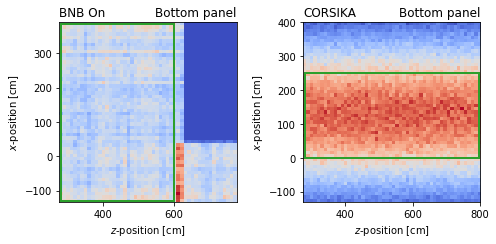

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5), sharex = False)

# y = -261.6
xz_data = ((min(df_crt.query('plane==0')['z']),max(df_crt.query('plane==0')['z'])),
           (min(df_crt.query('plane==0')['x']),max(df_crt.query('plane==0')['x'])))
print(xz_data)
ax[0].hist2d(df_crt.query('plane==0')['z'],df_crt.query('plane==0')['x'],
             cmap='coolwarm', bins=(50,52), range = xz_data)
ax[0].set_title("BNB On", loc='left')
ax[0].set_title("Bottom panel", loc='right')
ax[0].set_xlabel(r'$z$-position [cm]')
ax[0].set_ylabel(r'$x$-position [cm]')

# y = -258
xz_data = ((min(df_crt_mc['cross_z']),max(df_crt_mc['cross_z'])),
           (min(df_crt_mc['cross_x']),max(df_crt_mc['cross_x'])))
print(xz_data)
ax[1].hist2d(df_crt_mc['cross_z'],df_crt_mc['cross_x'],
             cmap='coolwarm', bins=(52,53), range = xz_data)
ax[1].set_title("CORSIKA", loc='left')
ax[1].set_title("Bottom panel", loc='right')
ax[1].set_xlabel(r'$z$-position [cm]')
ax[1].set_ylabel(r'$x$-position [cm]')


rect = patches.Rectangle((280,-130),320,515,
                         linewidth=2,edgecolor='C2',facecolor='none', label='TPC')
ax[0].add_patch(rect)
rect = patches.Rectangle((280,0),515,250,
                         linewidth=2,edgecolor='C2',facecolor='none', label='TPC')
ax[1].add_patch(rect)

fig.tight_layout()
plt.savefig(outdir+"bottom_hits2d_rect.pdf", bbox_inches="tight")

## MC only

In [12]:
print(df_crt_mc['mc_pdg_code'].value_counts()/len(df_crt_mc)*100)

-13      53.472103
 13      44.822845
 11       1.227342
-11       0.328644
 2212     0.107599
 211      0.023119
-211      0.018079
-2212     0.000269
Name: mc_pdg_code, dtype: float64


In [13]:
## Do also the 2 ways of estimating the rate using MC:
x_min = 0#-130
x_max = 250#400
x_q = '(cross_x<@x_max) & (cross_x>@x_min)'
#print(df_crt_mc['cross_z'].describe())
total_time = (4.05e-3+3.2e-3)*num_events_mc
area = (x_max-x_min)*(800-275)*1e-4 # in m*m
total_hits = len(df_crt_mc.query(x_q))
print(total_hits)
rate = total_hits/(total_time)/area
print(rate)

884919
232.72375824099962


In [14]:
# Can I see the dead time between panels? -> Time between hits plots!
df_crt_sorted_mc = df_crt_mc.query(x_q).sort_values(by=['event','run','subrun','cross_time']).copy()
df_crt_sorted_mc['dt_prev'] = (df_crt_sorted_mc['cross_time']-np.roll(df_crt_sorted_mc['cross_time'],1))/1000 
df_crt_sorted_mc['dt_next'] = (df_crt_sorted_mc['cross_time']-np.roll(df_crt_sorted_mc['cross_time'],-1))/1000 
df_crt_sorted_mc[['event','run','subrun','cross_time','dt_prev','dt_next','cross_z']].head(5)

,event,run,subrun,cross_time,dt_prev,dt_next,cross_z
433847,1,1,1,-3774444.25,-6918.334961,-189.523743,476.540497
502289,1,1,1,-3584920.50,189.523743,-68.580498,475.826508
74924,1,1,1,-3516340.00,68.580498,-73.860497,482.610504
74920,1,1,1,-3442479.50,73.860497,-39.749748,799.470703
433849,1,1,1,-3402729.75,39.749748,-44.440250,573.860901


-2.452589654290949 10.875015997773552
0.0277601118389921
[-2.45258965 10.87501609]
0.0013125
2452.589654290949
Rate = 186.9 +/- 2.1 [/m*m*s]


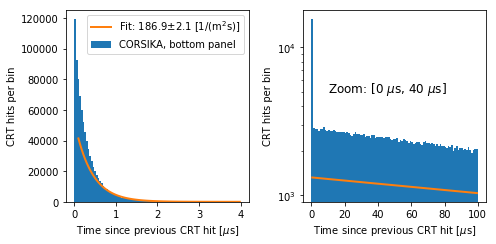

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5), sharex = False)

N=100
skip_bins = 2
x_max = 4000
x_max_zoom = 100
zoom = x_max/x_max_zoom

bins, edges, _ = ax[0].hist(df_crt_sorted_mc['dt_prev']/1000, bins=N, 
                            range=(0,x_max/1000), label='CORSIKA, bottom panel')
centers = edges[:-1] + np.diff(edges)/2

#--fit--------------------------------------------------------------------------------------
slope, intercept, r_value, p_value, std_err = linregress(centers[skip_bins:], np.log(bins[skip_bins:]))
coefs = np.polyfit( centers[skip_bins:],np.log(bins[skip_bins:]),1)
ffit = poly.polyval(centers, [intercept,slope])
print(slope, intercept)
print(std_err)
print(coefs)
#--------------------------------------------------------------------------------------------

ax[0].plot(centers[skip_bins:],np.exp(ffit[skip_bins:]), lw=2,
           label = r"Fit: {0:.1f}$\pm${1:.1f} [1/(m$^2$s)]".format(slope*-1000/area, std_err*1000/area ))
ax[0].set_xlabel(r'Time since previous CRT hit [$\mu$s]')
ax[0].set_ylabel('CRT hits per bin')
ax[0].legend()

bins, edges, _ = ax[1].hist(df_crt_sorted_mc['dt_prev'], bins=N, range=(0,x_max_zoom))
centers = edges[:-1] + np.diff(edges)/2
ffit = poly.polyval(centers, [intercept,slope/1000])
ax[1].plot(centers,np.exp(ffit)/zoom, label = 'exp fit', lw=2)
ax[1].set_xlabel(r'Time since previous CRT hit [$\mu$s]')
ax[1].set_yscale("log", nonposy='clip')
ax[1].set_ylabel('CRT hits per bin')
ax[1].text(10,5e3,r'Zoom: [0 $\mu$s, 40 $\mu$s]', fontsize=12)

fig.tight_layout()

# Final rate of CRT hits per m*m*s:
print(area*1e-4)
print(-slope*1000)
print(r"Rate = {0:.1f} +/- {1:.1f} [/m*m*s]".format(slope*-1000/area, std_err*1000/area ) )

plt.savefig(outdir+"exp_fit_bottom_mc.pdf", bbox_inches="tight")

## Data only

In [26]:
# Fraction of hits in the bottom plane
df_crt['plane'].value_counts()/len(df_crt)*100

3    54.792723
2    21.516487
1    12.614122
0    11.076667
Name: plane, dtype: float64

In [27]:
# Area used to do the rate measurement
z_max = 600
area = (z_max-276.73)*(400+129.95)*1e-4 #in m*m
z_q = 'z<@z_max'

In [28]:
# Rate from totel hits / total time: 
total_hits = len(df_crt.query('plane==0').query(z_q))
total_time = (4068.6+1931.4)*num_events_data/1e6   # in seconds
rate = total_hits/(total_time)/area
print(rate)

95.1021760329593


In [29]:
time_min = -2.5e5 
time_max = -1*time_min
mask = df_crt.query('plane==0').query(z_q)['time'].between(time_min,time_max)
sum(mask)/len(mask)
df_crt.query('plane==0').query(z_q)['time'][mask].describe()

count    251265.000000
mean       1053.748291
std        1728.893677
min       -1931.394043
25%        -422.606995
50%        1031.171997
75%        2553.177979
max        4068.593994
Name: time, dtype: float64

In [30]:
# Can I see the dead time between panels? -> Time between hits plots!
df_crt_sorted = df_crt.query('plane==0').query(z_q).sort_values(by=['event','run','subrun','time']).copy()
df_crt_sorted['dt_prev'] = df_crt_sorted['time']-np.roll(df_crt_sorted['time'],1) 
df_crt_sorted['dt_next'] = df_crt_sorted['time']-np.roll(df_crt_sorted['time'],-1) 
df_crt_sorted[['event','run','subrun','time','dt_prev','dt_next','z']].head(5)

,event,run,subrun,time,dt_prev,dt_next,z
993219,1,15356,0,-1306.281982,-5045.534180,-340.898010,543.558899
993221,1,15356,0,-965.383972,340.898010,-1125.824951,411.647156
993222,1,15356,0,160.440994,1125.824951,-219.048996,511.656342
993223,1,15356,0,379.489990,219.048996,-188.595032,519.301331
993224,1,15356,0,568.085022,188.595032,-761.549011,512.177917


-1.803200718875283 8.989823972891282
0.005998511225064941
[-1.80320072  8.98982401]
0.0017131693650000003
1803.200718875283
Rate = 105.3 +/- 0.4 [/m*m*s]


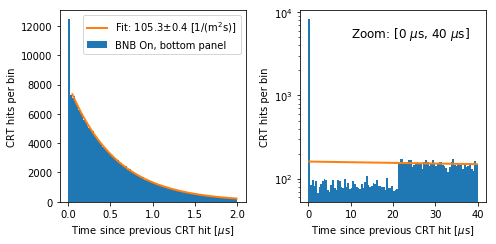

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5), sharex = False)

N=100
skip_bins = 2
x_max = 2000
x_max_zoom = 40
zoom = x_max/x_max_zoom

bins, edges, _ = ax[0].hist(df_crt_sorted['dt_prev']/1000, bins=N, 
                            range=(0,x_max/1000), label='BNB On, bottom panel')
centers = edges[:-1] + np.diff(edges)/2

#--fit--------------------------------------------------------------------------------------
slope, intercept, r_value, p_value, std_err = linregress(centers[skip_bins:], np.log(bins[skip_bins:]))
coefs = np.polyfit( centers[skip_bins:],np.log(bins[skip_bins:]),1)
ffit = poly.polyval(centers, [intercept,slope])
print(slope, intercept)
print(std_err)
print(coefs)
#--------------------------------------------------------------------------------------------

ax[0].plot(centers[skip_bins:],np.exp(ffit[skip_bins:]), lw=2,
           label = r"Fit: {0:.1f}$\pm${1:.1f} [1/(m$^2$s)]".format(slope*-1000/area, std_err*1000/area ))
ax[0].set_xlabel(r'Time since previous CRT hit [$\mu$s]')
ax[0].set_ylabel('CRT hits per bin')
ax[0].legend()

bins, edges, _ = ax[1].hist(df_crt_sorted['dt_prev'], bins=N, range=(0,x_max_zoom))
centers = edges[:-1] + np.diff(edges)/2
ffit = poly.polyval(centers, [intercept,slope/1000])
ax[1].plot(centers,np.exp(ffit)/zoom, label = 'exp fit', lw=2)
ax[1].set_xlabel(r'Time since previous CRT hit [$\mu$s]')
ax[1].set_yscale("log", nonposy='clip')
ax[1].set_ylabel('CRT hits per bin')
ax[1].text(10,5e3,r'Zoom: [0 $\mu$s, 40 $\mu$s]', fontsize=12)

fig.tight_layout()

# Final rate of CRT hits per m*m*s:
print(area*1e-4)
print(-slope*1000)
print(r"Rate = {0:.1f} +/- {1:.1f} [/m*m*s]".format(-1*slope*1000/area, std_err*1000/area ) )

plt.savefig(outdir+"exp_fit_bottom.pdf", bbox_inches="tight")

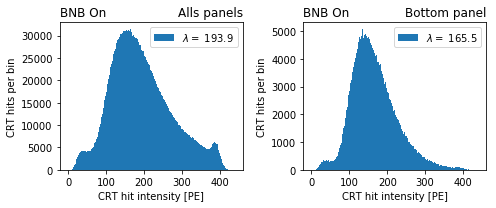

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3), sharex = True)

ax[0].hist(df_crt['pe'], range=(0,439), bins=220,
           label = r"$\lambda =$ {0:.1f}".format(df_crt['pe'].mean()))
ax[0].set_title("BNB On", loc='left')
ax[0].set_title("Alls panels", loc='right')
ax[0].set_xlabel(r'CRT hit intensity [PE]')
ax[0].set_ylabel(r'CRT hits per bin')
ax[0].legend()

ax[1].hist(df_crt.query('plane==0')['pe'], range=(0,439), bins=220,
           label = r"$\lambda =$ {0:.1f}".format(df_crt.query('plane==0')['pe'].mean()))
ax[1].set_title("BNB On", loc='left')
ax[1].set_title("Bottom panel", loc='right')
ax[1].set_xlabel(r'CRT hit intensity [PE]')
ax[1].set_ylabel(r'CRT hits per bin')
ax[1].legend()

fig.tight_layout()
plt.savefig(outdir+"pe_hits.pdf", bbox_inches="tight")